### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import jsonlines

### Read the simulation output

First as raw JSON lines

In [2]:
BASELINE = '../data/history_file_baseline_2agents.json'
FAIRNESS_LOTTERY = '../data/history_file_fairness_lottery_2agents.json'
LEAST_FAIR = '../data/history_file_least_fair_2agents.json'
MOST_COMPATIBLE = '../data/history_file_most_compatible_2agents.json'
PRODUCT_LOTTERY = '../data/history_file_product_lottery_2agents.json'
STATIC_LOTTERY = '../data/history_file_static_lottery_2agents.json'

In [3]:
history_files = [BASELINE,FAIRNESS_LOTTERY,LEAST_FAIR,MOST_COMPATIBLE,PRODUCT_LOTTERY,STATIC_LOTTERY]

baseline = []
fairness_lottery = []
least_fair = []
most_compatible = []
product_lottery = []
static_lottery = []

list_names = [baseline,fairness_lottery,least_fair,most_compatible,product_lottery,static_lottery]

In [4]:
for history_file, list_name in zip(history_files,list_names):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            list_name.append(obj)


Functions to process the history

In [5]:
def process_history(history, fair=True, compat=True, alloc=True, lists=True):
    if fair:
        fair_list = [entry['allocation']['fairness scores'] for entry in history]
        fair_df = pd.DataFrame(fair_list)
    else:
        fair_df = None
        
    if compat:
        compat_list = [entry['allocation']['compatibility scores'] for entry in history]
        compat_df = pd.DataFrame(compat_list)
    else:
        compat_df = None
        
    if alloc:
        alloc_list = [entry['allocation']['output'] for entry in history]
        alloc_df = pd.DataFrame(alloc_list)
        alloc_df['none'] = (alloc_df['1'] == 0) & (alloc_df['2'] == 0)
    else:
        alloc_df = None
        
    if lists:
        results_list = [process_results(entry['choice_out']['results']) for entry in history]
    else:
        results_list = None
    
        
    return fair_df, compat_df, alloc_df, results_list

def process_results(result_structs):
    
    return [(entry['item'], entry['score']) for entry in result_structs]

        

Get the individual data frames and result lists

In [6]:
fair_df_baseline, compat_df_baseline, alloc_df_baseline, results = process_history(baseline)
fair_df_fairness_lottery, compat_df_fairness_lottery, alloc_df_fairness_lottery, results = process_history(fairness_lottery)
fair_df_least_fair, compat_df_least_fair, alloc_df_least_fair, results = process_history(least_fair)
fair_df_most_compatible, compat_df_most_compatible, alloc_df_most_compatible, results_most_compatible = process_history(most_compatible)
fair_df_product_lottery, compat_df_product_lottery, alloc_df_product_lottery, results_product_lottery = process_history(product_lottery)
fair_df_static_lottery, compat_df_static_lottery, alloc_df_static_lottery, results_static_lottery = process_history(static_lottery)

In [7]:
fair_df = pd.DataFrame()

In [8]:
#Total sum per row: 
fair_df.loc[:,'Baseline'] = fair_df_baseline.sum(axis=1)
fair_df.loc[:,'Fairness Lottery'] = fair_df_fairness_lottery.sum(axis=1)
fair_df.loc[:,'Least Fair'] = fair_df_least_fair.sum(axis=1)
fair_df.loc[:,'Most Campatible'] = fair_df_most_compatible.sum(axis=1)
fair_df.loc[:,'Product Lottery'] = fair_df_product_lottery.sum(axis=1)
fair_df.loc[:,'Static Lottery'] = fair_df_static_lottery.sum(axis=1)

In [9]:
fair_df

,Baseline,Fairness Lottery,Least Fair,Most Campatible,Product Lottery,Static Lottery
0,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
1,0.000000,1.222222,1.000000,1.000000,1.222222,1.222222
2,0.222222,1.555556,1.444444,1.222222,1.555556,1.333333
3,0.296296,1.666667,1.592593,1.296296,1.666667,1.518519
4,0.444444,1.777778,1.722222,1.444444,1.777778,1.666667
...,...,...,...,...,...,...
95,0.624561,1.873684,1.887719,1.708772,1.866667,1.743860
96,0.629630,1.875000,1.888889,1.712963,1.868056,1.747685
97,0.634593,1.878580,1.892325,1.717068,1.871707,1.751432
98,0.634921,1.875283,1.888889,1.716553,1.868481,1.750567


## Visualizations

Simple plot of the fairness values computed at each iteration

In [10]:
def plot_fairness_time(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness")
    sb.lineplot(data=fair_df)
    image_file = image_prefix + '-fairness.png'
    plt.savefig(image_file)
                

In [11]:
def plot_allocation(experiment_data, include_none=False, image_prefix=None):
    alloc_df = pd.DataFrame(experiment_data[2])
    if include_none is False:
        if not alloc_df['none'][1:].any():
            alloc_df.drop('none', axis=1, inplace=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Allocation")
    sb.lineplot(data=alloc_df.cumsum())
    image_file = image_prefix + '-allocation.png'
    plt.savefig(image_file)

In [12]:
def plot_fairness_regret(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    regret = 1-fair_df
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness Regret")
    sb.lineplot(data=regret.cumsum())
    image_file = image_prefix + '-regret.png'
    plt.savefig(image_file)

In [13]:
def do_plots(experiment_data, include_none=False, image_prefix=None):
    plot_fairness_time(experiment_data, include_none, image_prefix)
    plot_allocation(experiment_data, include_none, image_prefix)
    plot_fairness_regret(experiment_data, include_none, image_prefix)
    

In [14]:
def process(experiment, include_none=False, image_prefix=None):
    experiment_data = process_history(experiment)
    
    do_plots(experiment_data, include_none, image_prefix)

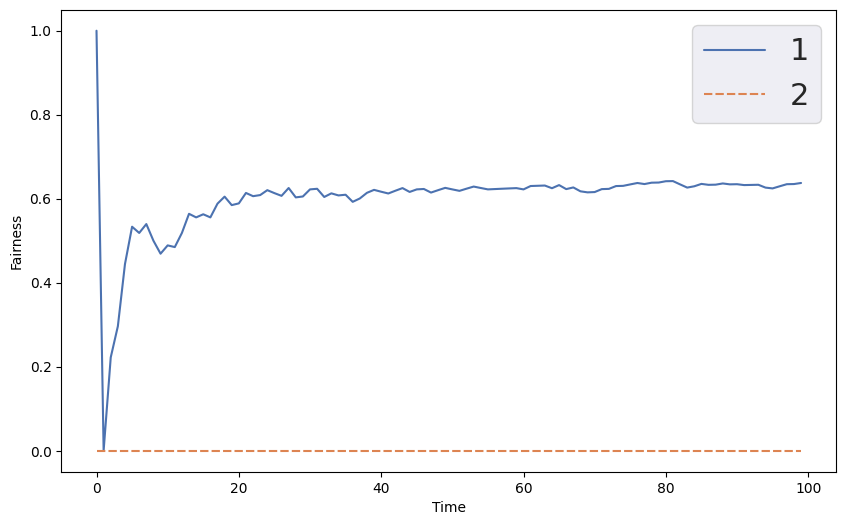

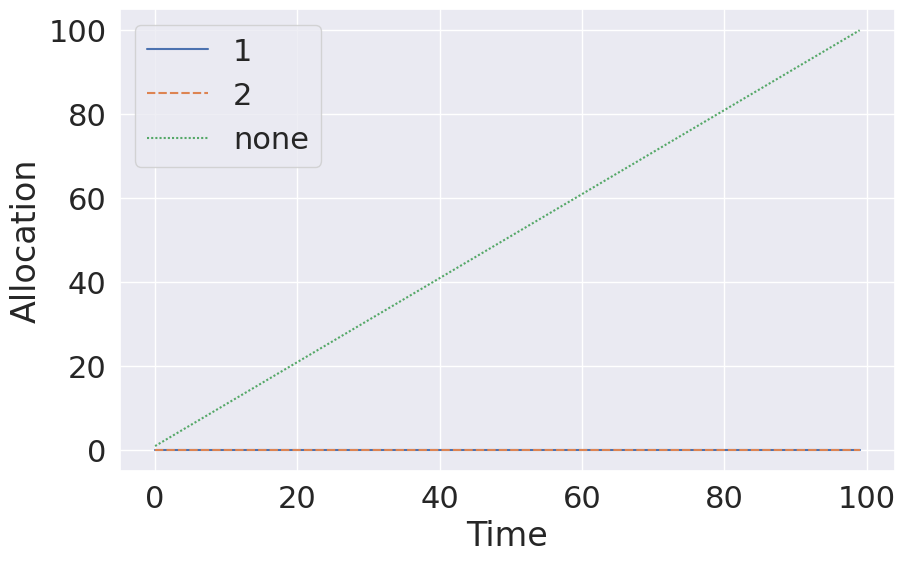

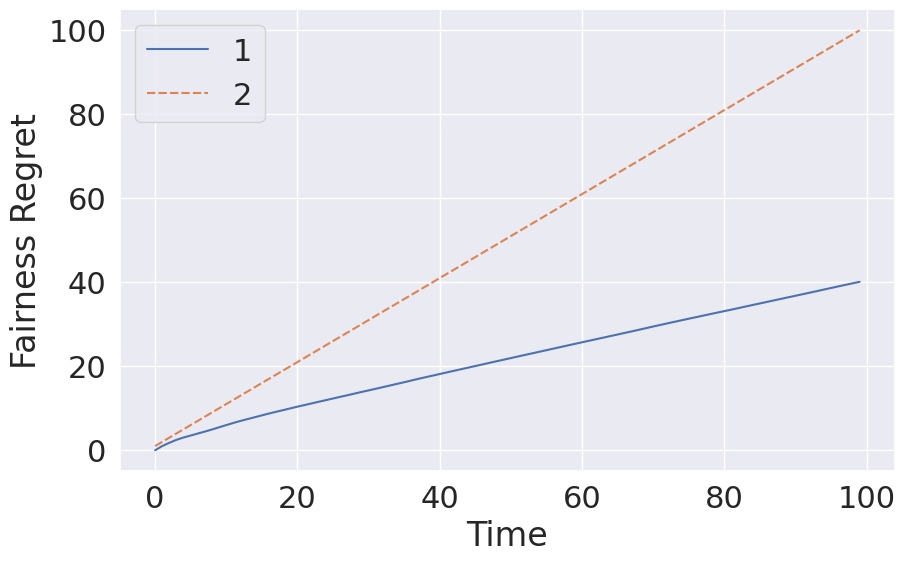

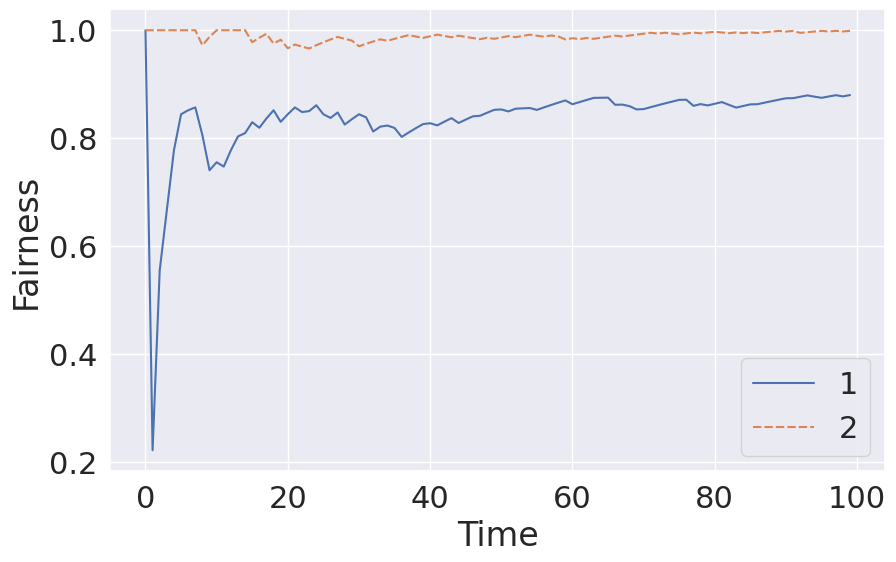

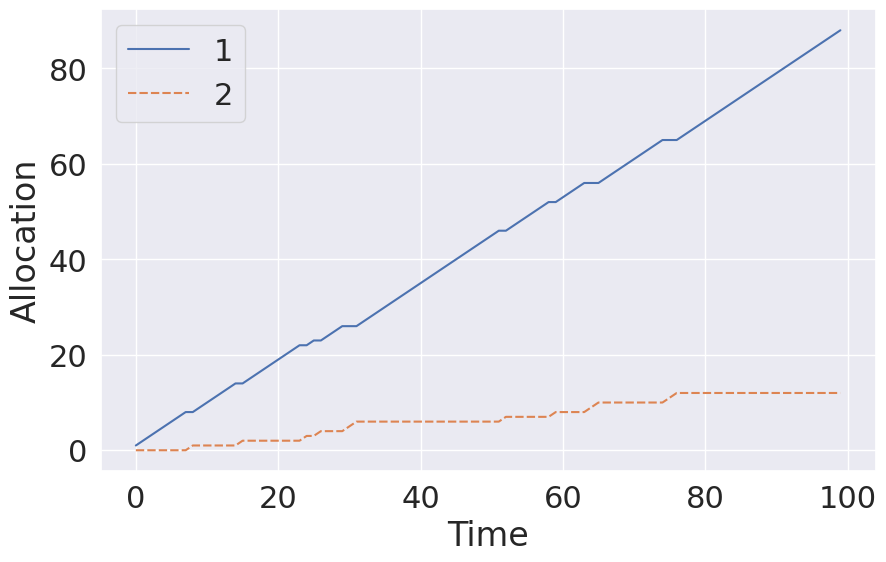

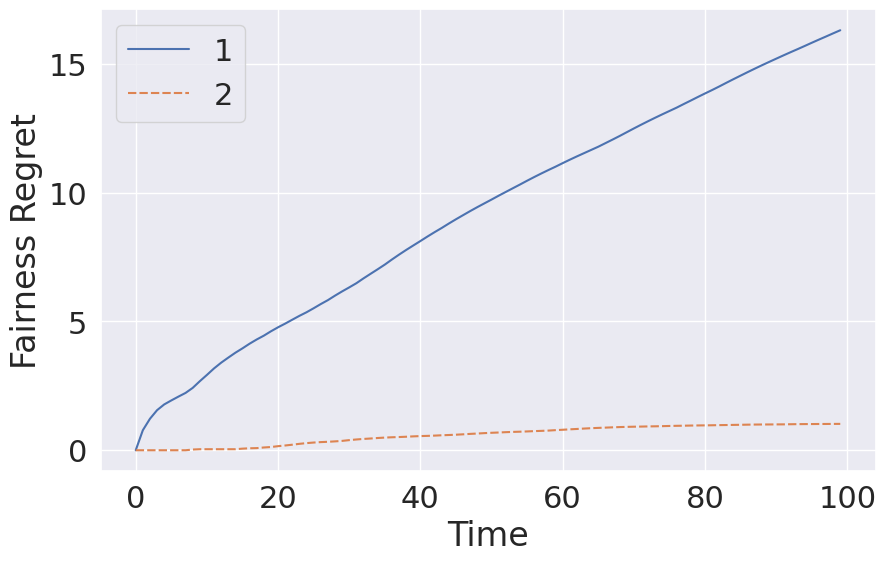

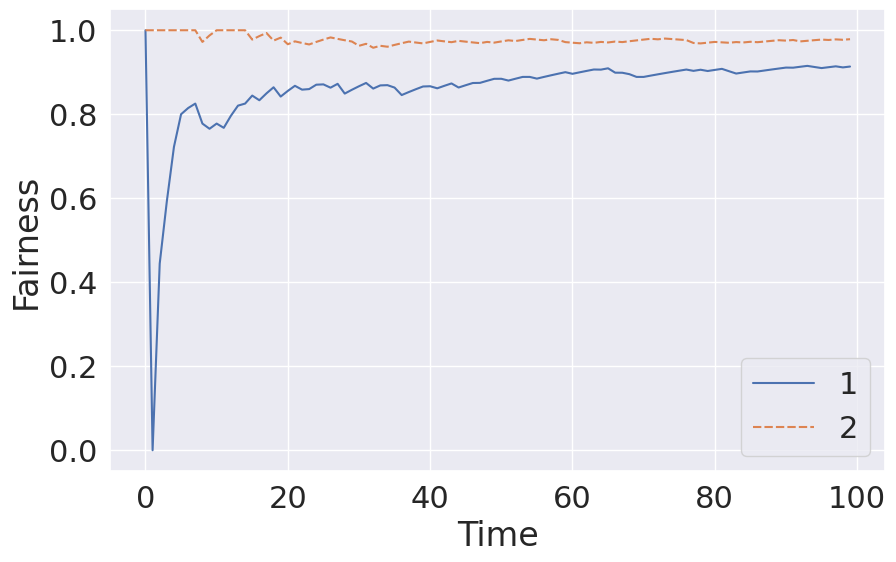

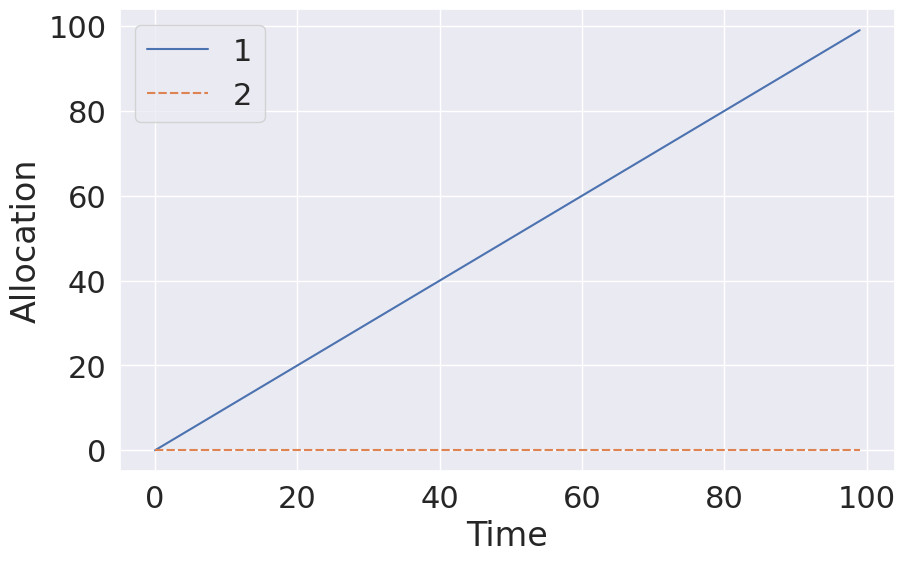

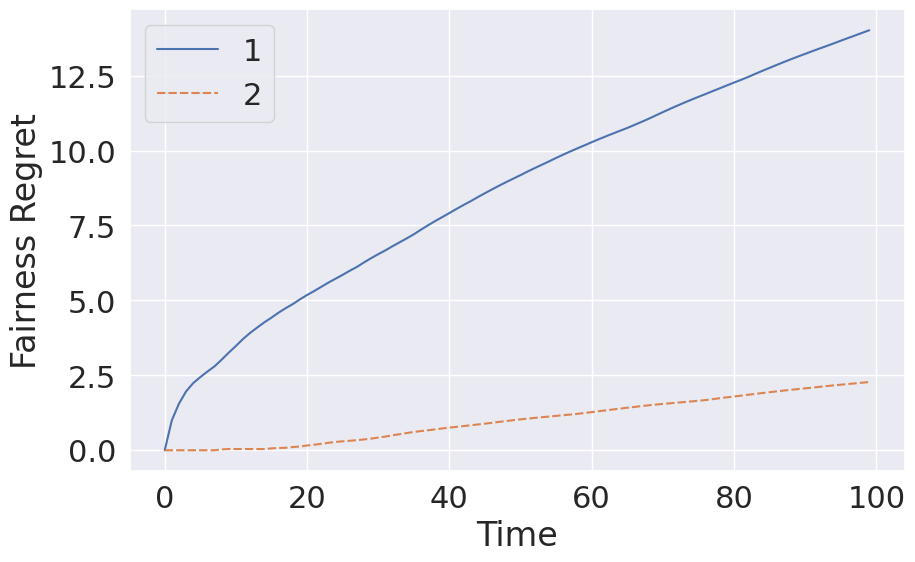

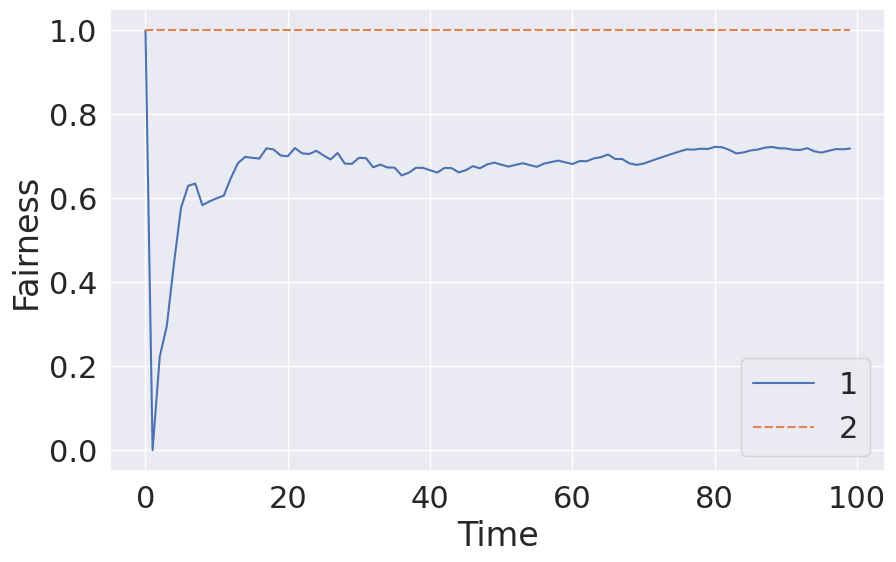

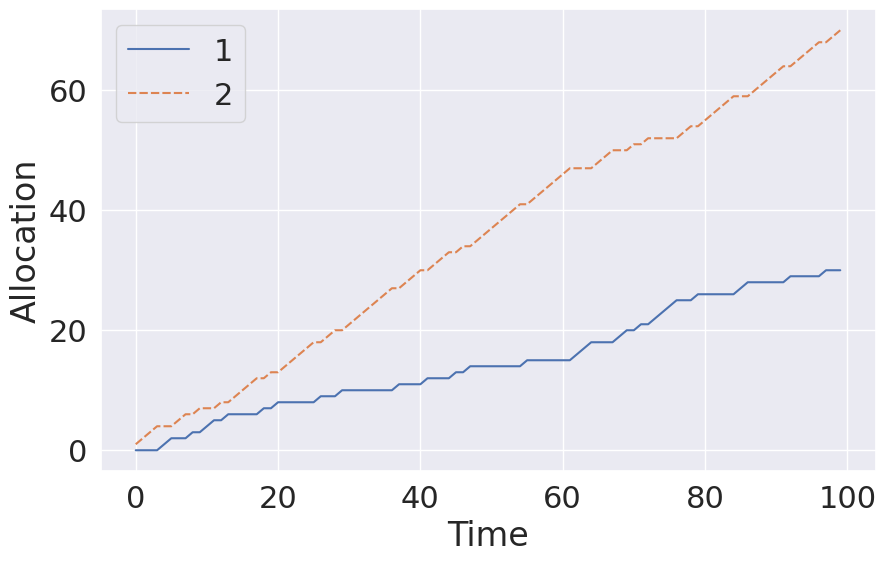

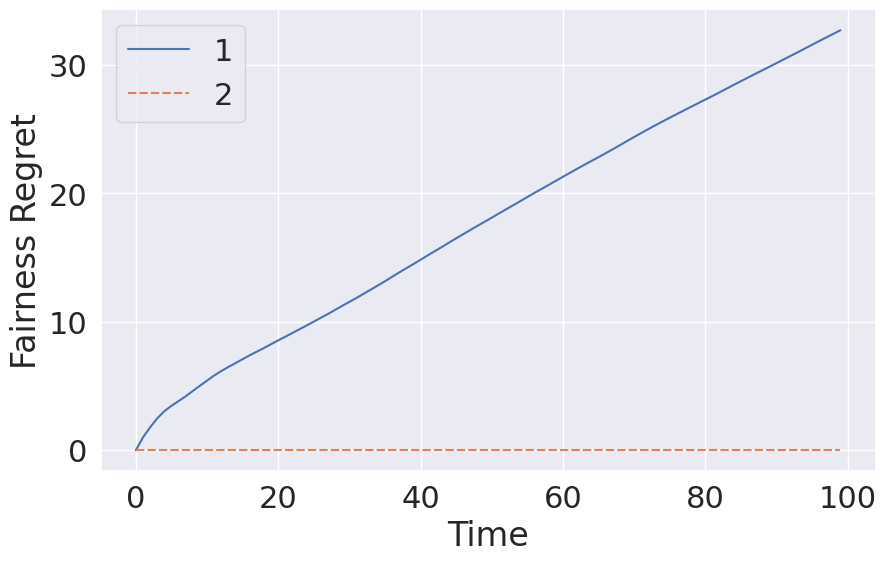

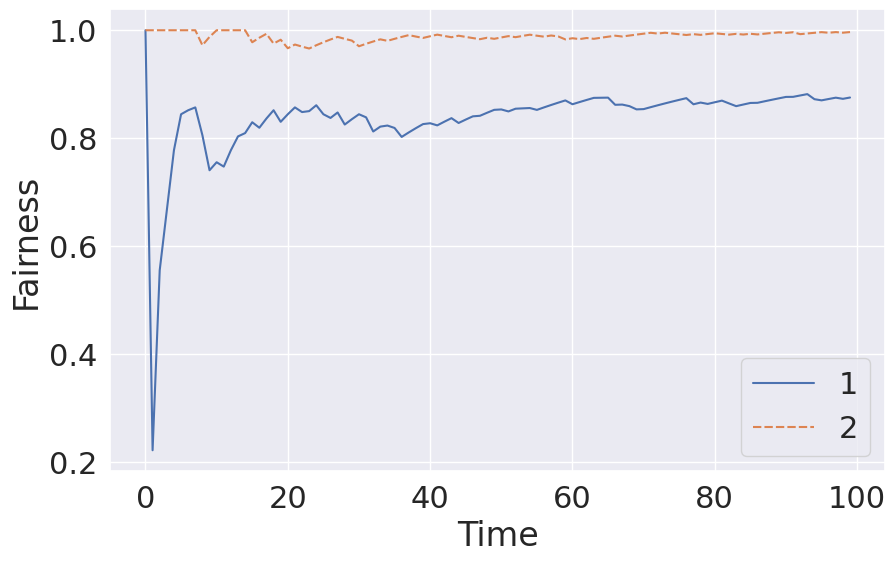

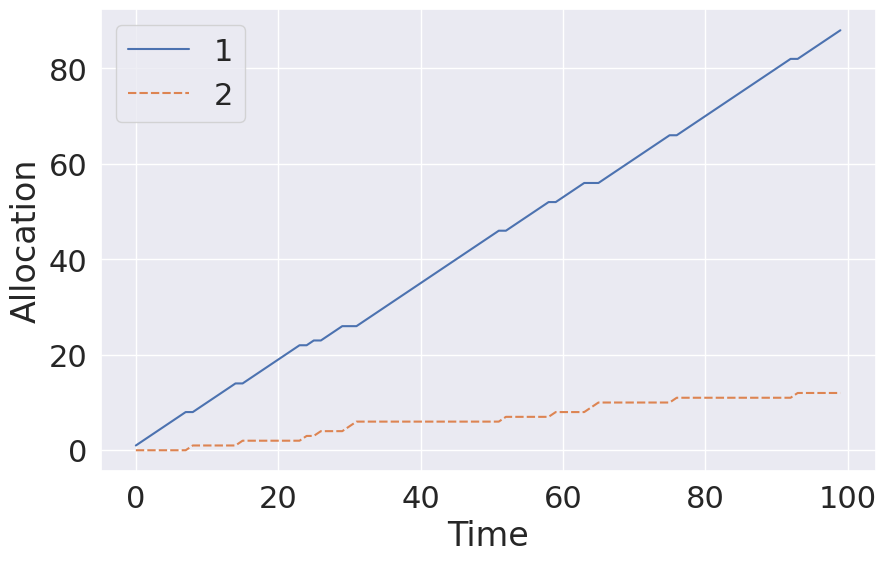

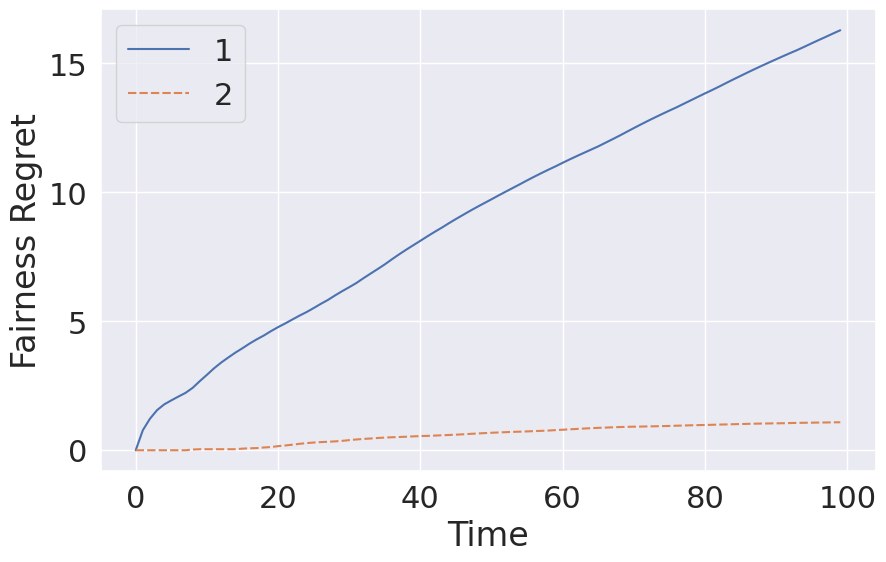

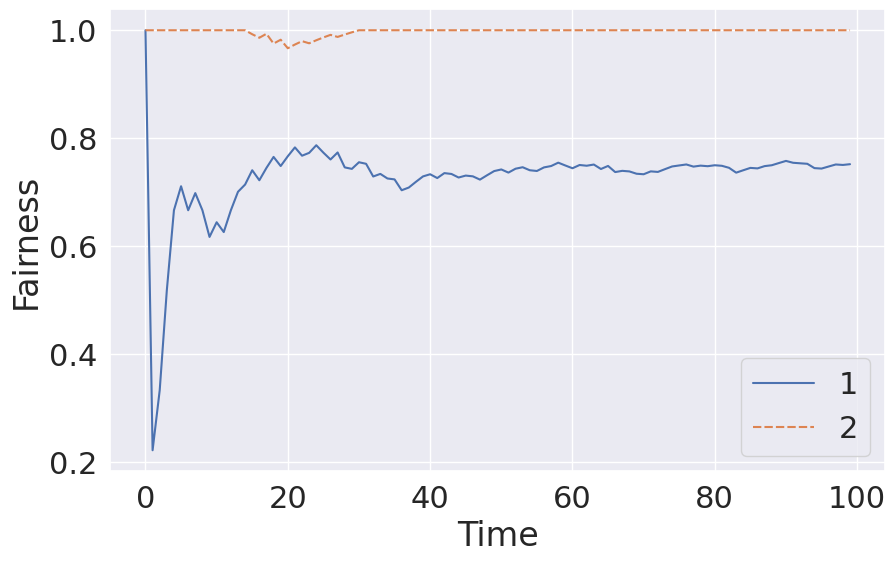

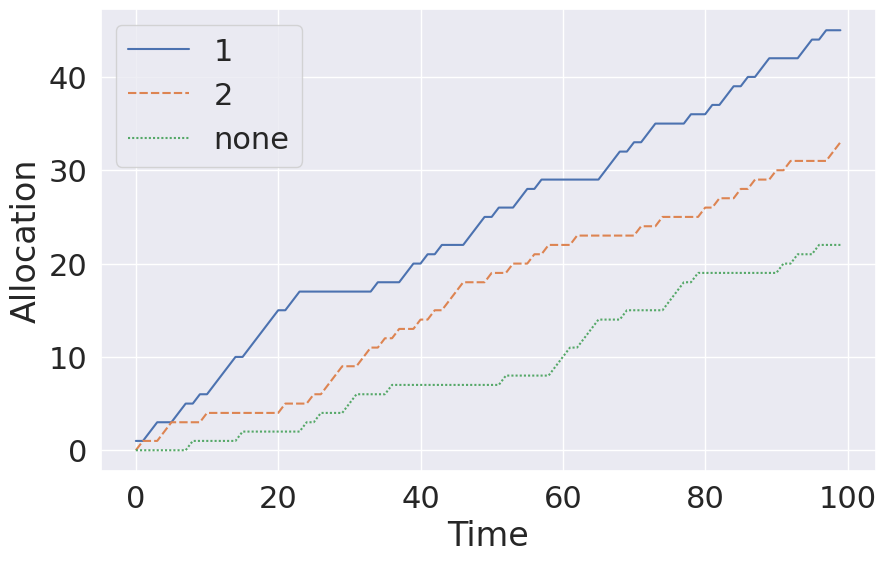

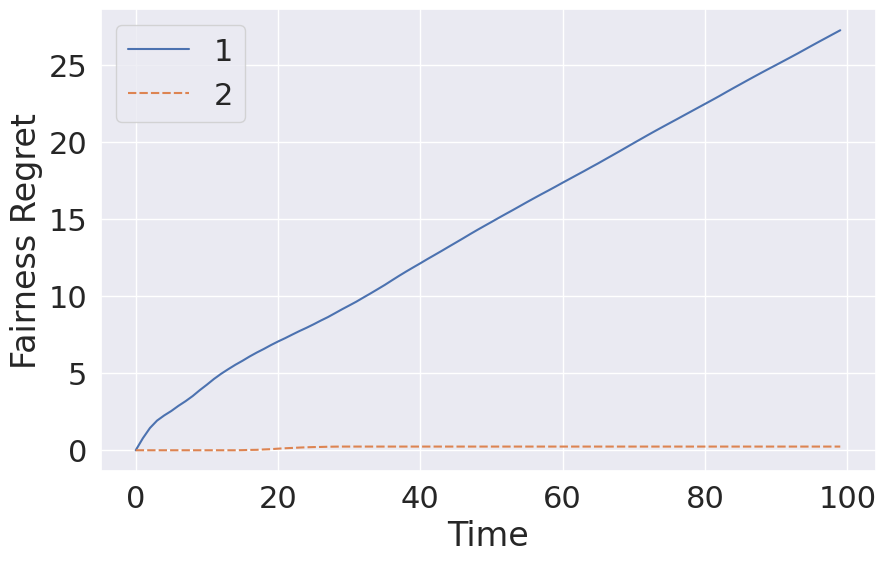

In [15]:
process(baseline, image_prefix='baseline')
process(fairness_lottery, image_prefix='fairness_lottery')
process(least_fair, image_prefix='least_fair')
process(most_compatible, image_prefix='most_compatible')
process(product_lottery, image_prefix='product_lottery')
process(static_lottery, image_prefix='static_lottery')

In [ ]:
alloc_df_least_fair

In [ ]:
plot_allocation_time(most_compat)

In [ ]:
# Set up the plot
sb.set(style="ticks")
fig, ax = plt.subplots(figsize=(10, 6))
# Add title and axis labels
ax.set_title("Average_Fairness")
ax.set_xlabel("agent")
ax.set_ylabel("Fairness")
# Draw the boxplot
sb.boxplot(x="agent", y="Fairness", hue="variable", data=fair_df_static, ax=ax)
# Remove unnecessary elements
sb.despine(trim=True, left=True)
# Adjust the aspect ratio
plt.tight_layout()

In [ ]:
fair_

In [ ]:
sb.lineplot(data=fair_df_fair_100)

In [ ]:
sb.lineplot(data=alloc_df_fair_100.cumsum())

In [ ]:
alloc_df_most_compat['none'] = (alloc_df_most_compat['Agent1'] == 0) & (alloc_df_most_compat['Agent2'] == 0)

In [ ]:
alloc_df_melt = alloc_df_most_compat.reset_index().melt(id_vars=['index'])
alloc_df_melt1 = alloc_df_melt[alloc_df_melt['value']==1]
sb.stripplot(data=alloc_df_melt1, x='index', y='variable', hue='variable', alpha=0.25, jitter=0.01)

In [ ]:
1-(fair_df/2)

In [ ]:
#All algorithms
regret = 1-(fair_df/2)
fig, ax = plt.subplots(figsize=(10, 6))
sb.set(font_scale=1.75)
ax.set_xlabel("Time")
ax.set_ylabel("Fairness Regret")
sb.lineplot(data=regret.cumsum())
fig.savefig('total_fairnessregret.png')

In [ ]:
fair_melt = pd.melt(fair_df)

In [ ]:
#All algorithms

fair_df.boxplot()

In [ ]:
fair_df_melt = fair_df.reset_index().melt(id_vars=['index'])
fig, ax = plt.subplots(figsize=(10, 6))
sb.set(font_scale=1.75)
fig = sb.boxplot(data=fair_df_melt, x='value', y='variable', orient='h')
fig.set(xlabel ="Fairness", ylabel = "Allocation Mechanism")
plt.savefig('boxplot_fairness.png')

In [ ]:
fair_df_melt = fair_df.reset_index().melt(id_vars=['index'])
fair_df_melt

Same for allocation

In [ ]:
alloc_df_melt = alloc_df.reset_index().melt(id_vars=['index'])
sb.stripplot(data=alloc_df_melt, x='index', y='value', hue='variable', dodge=True)

In [ ]:
fair_df.boxplot()

In [ ]:
# Store the list of columns
columns_to_plot = ['Agent1','Agent2','Agent3']

# Create the figure and two subplots
fig, axes = plt.subplots(ncols=len(columns_to_plot))

# Create the boxplot with Seaborn
for column, axis in zip(columns_to_plot, axes):
        sb.boxplot(data=fair_df[column], x='index', y='value', hue = 'variable', ax = axis) 
        axis.set_title(column)


# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
sb.stripplot(data=fair_df_melt, x='index', y='value', hue='variable', dodge=True)

In [ ]:
sb.stripplot(data=alloc_df_melt, x='index', y='value', hue='variable', dodge=True)

In [ ]:
sb.boxplot(data=alloc_df_melt, x='index', y='value', hue='variable')

In [ ]:
item_data = pd.read_csv('../Data/item.csv', header=None)
item_data.columns = ['item', 'agent', 'protected']


In [ ]:
item_data = item_data.set_index('item')

In [ ]:
# assumes that there's only one protected feature per item
# ok for these experiments
def count_protected(agent, result_entries):
    return sum([1 if item_data.loc[int(result[0]), 'agent'] == agent else 0 for result in result_entries])
    
def count_all_protected(agent, results):
    return sum([count_protected(agent, result_entries) for result_entries in results])

In [ ]:
histories = {'baseline': baseline, 
             'least_misery': least_fair,
             'most_compat' : most_compat,
             'static' : static,
             'fair_lottery': fair_lottery,
             'weighted_alloc': weighted_lottery}


def compute_results(history):
    _, _, _, results = process_history(history, fair=False, compat=False, alloc=False, lists=True)
    return results

result_dict = {name: compute_results(history) for name, history in histories.items()}


In [ ]:
count_dict0 = {name: count_all_protected(0, results) for name, results in result_dict.items()}

In [ ]:
count_dict1 = {name: count_all_protected(1, results) for name, results in result_dict.items()}

In [ ]:
count_dict2 = {name: count_all_protected(2, results) for name, results in result_dict.items()}

In [ ]:
count_dict1

In [ ]:
count_dict2

In [ ]:
count_df = pd.DataFrame([count_dict0, count_dict1, count_dict2])

In [ ]:
count_df

In [ ]:
count_df/10000